In [1]:
import numpy as np
import pandas as pd
from os import listdir
from numpy import genfromtxt

## Get data

In [35]:
studyname = 'Utrecht' 
fileindex = 0

In [38]:
def getdata(studyname,fileindex):
    if studyname == 'Utrecht':
        #datadir = "/home/vincent/estep/data/utrecht"
        datadir = "/media/windows-share/utrecht_eeg"
        multivar = True #False # Are this Multivariate time series TRUE or FALSE
        multiclass = False
        Nfilesperelement = 4 #there are four files per patient
        labloc = "/home/vincent/estep/data/utrecht_labels.csv" # labels in column 1 (0), row 1 (1), or name of file
        idbloc = 2 # Id in column 1 (0), row 1 (1), seperate file (2), not applicable (3)
        timecol = False # time series per column (True) or per row (False)
    elif studyname == 'UCR':
        datadir = "/home/vincent/estep/data/UCR_TS_Archive_2015/50words"
        multivar = False # Are this Multivariate time series TRUE or FALSE
        multiclass = False
        Nfilesperelement = 0 #all elements are in one merged file
        labloc = 0 # Classifcation labels in column 1 (0), row 1 (1), seperate file (2)
        idbloc = 3 # Id in column 1 (0), row 1 (1), seperate file (2), not applicable (3)
        timecol = False # time series per column (True) or per row (False)
    else:
        raise ValueError(str(studyname) + ' is not a valid studyname')
    #============================================================================
    # Identify number of files and filetype based on datadir
    filenames = listdir(datadir)
    Nfiles = len(filenames) # number of files
    # Investigate what format the first file has by trying out a variety of reading attempts

    path = datadir + '/' + filenames[fileindex]
    delimiter = [None,','] #possible delimiter values
    skiprows=[0,1]
    ntests = len(delimiter)*len(skiprows)
    df = pd.DataFrame(index=range(ntests),columns=['delimiter','skiprows','nrow','ncol','first cell'])
    cnt = 0
    for di in delimiter:
        for si in skiprows:
            try:
                F1 = np.loadtxt(fname=path,delimiter=di,skiprows=si)
                df['delimiter'][cnt] = di
                df['skiprows'][cnt] = si
                df['nrow'][cnt] = F1.shape[0]
                df['ncol'][cnt] = F1.shape[1]
                df['first cell'][cnt] = F1[0,1]
            except:
                df['delimiter'][cnt] = di
                df['skiprows'][cnt] = si
                df['nrow'][cnt] = 0
                df['ncol'][cnt] = 0
                df['first cell'][cnt] = 0
            cnt = cnt + 1
    # df is now a dataframe with information to help identify how the data should be loaded
    # load one file based on the extracted information on fileformat
    form = df[df.nrow == max(df.nrow)] # extraction procedure that resulted in the largest number of rows is the best
   
    if form.shape[0] > 1:
        form = df[df.ncol == max(df.ncol)] # extraction procedure that resulted in the largest number of columns
    if (form['delimiter'] == ',').bool():
        F2 = np.loadtxt(fname=path,delimiter=',',skiprows=int(form['skiprows']))
    else:
        F2 = np.loadtxt(fname=path,delimiter=None,skiprows=int(form['skiprows']))
    # Extract labels y and data X, and standardize shape of matrix
    # Extract data based on newly gained insight into fileformat and data structure
    labtype = 'int'
    if type(labloc) == str:
        #y = genfromtxt(labloc, delimiter=',',skip_header=1) # do we want numpy array or pd dataframe?
        y = pd.read_csv(labloc, sep=',',header=0)
        #y=pd.read_csv(labloc, sep=',',header=None)
        # TO DO: y needs to be converted in simple one dimensional array that alligns with X
        # - how can we verify which time series links to which label...both should have a unique key
        # - in case of utrecht, the key is in the id in the filename, which is also in y
        # - is this generic for all seperate file?
        # - no, if there is one class per id then we know that it is file level
        # - if there are multiple classes per id (e.g. London data) then we know that it is both between and
        # within files
        if timecol == False:
            X = F2.transpose()
        else:
            X = F2    
    elif type(labloc) == int:
        if labloc == 0:
            y = np.array(F2[:,0], dtype=labtype)
            X = F2[:,1:]
        elif labloc == 1:
            y = np.array(F2[0,:], dtype=labtype)
            X = F2[1:,:].transpose()
    filename = filenames[fileindex]
    return(X, y, filename, Nfiles)

In [39]:
# get data
Xtrain, ytrain, filenametrain, Nfiles = getdata(studyname,fileindex=0)
Xtest, ytest, filenametest, Nfiles = getdata(studyname,fileindex=1)

In [40]:
print(Xtrain.shape, ytrain.shape, filenametrain, Nfiles)
print(Xtest.shape, ytest.shape, filenametest, Nfiles)

(21, 4606) (451, 4) 451_ep1.TRC.txt 1152
(21, 4472) (451, 4) 451_ep2.TRC.txt 1152


In [43]:
Xtrain.shape

(21, 4606)

# Design and compile some architectures

In [6]:
# Now, lets try to train some models
from keras.models import Sequential
from keras.layers import Merge, Dense, Dropout, Activation, LSTM
from keras.optimizers import SGD
import numpy as np
from keras.utils.np_utils import to_categorical

Using Theano backend.


In [7]:
#ytrain[ytrain.columns[3]]

In [13]:
timesteps = Xtrain.shape[1]
data_dim = 1
nb_classes = 51
X_train = Xtrain #np.random.random((100, timesteps))
y_train = ytrain #np.random.randint(nb_classes,size=(100,1))
X_test = Xtest #np.random.random((100, timesteps))
y_test = ytest #np.random.randint(nb_classes,size=(100,1))
y_train_original = y_train
y_test_original = y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
idim = timesteps
model.add(Dense(64, input_dim=idim, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, init='uniform'))
model.add(Activation('softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [15]:
# reshape data, because LSTM requires different input format?
X_train2 = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test2 = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [16]:
# let's try out another model
model2 = Sequential()
model2.add(LSTM(32, return_sequences=True,
               input_shape=(X_train2.shape[1], X_train2.shape[2])))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32))  # return a single vector of dimension 32
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Fit the architectures / models

In [32]:
#Fit model and store history of the fitting process
History = model.fit(X_train, y_train,
          nb_epoch=5,batch_size=20,validation_split=0.2)

Train on 360 samples, validate on 90 samples
Epoch 1/5
360/360 [==============================] - 0s - loss: 5.0812 - acc: 0.1194 - val_loss: 6.9773 - val_acc: 0.2000
Epoch 2/5
360/360 [==============================] - 0s - loss: 5.4725 - acc: 0.1250 - val_loss: 6.8237 - val_acc: 0.2000
Epoch 3/5
360/360 [==============================] - 0s - loss: 5.3635 - acc: 0.1139 - val_loss: 6.8700 - val_acc: 0.2000
Epoch 4/5
360/360 [==============================] - 0s - loss: 5.1136 - acc: 0.1000 - val_loss: 6.0435 - val_acc: 0.1444
Epoch 5/5
360/360 [==============================] - 0s - loss: 4.6833 - acc: 0.1167 - val_loss: 5.4793 - val_acc: 0.1111


In [18]:
#Fit model and store history of the fitting process
History2 = model2.fit(X_train2, y_train,batch_size=20,
                      nb_epoch=5,verbose=True,validation_split=0.2)

Train on 360 samples, validate on 90 samples
Epoch 1/5
360/360 [==============================] - 6s - loss: 3.7842 - acc: 0.1056 - val_loss: 3.6224 - val_acc: 0.1667
Epoch 2/5
360/360 [==============================] - 6s - loss: 3.6084 - acc: 0.1611 - val_loss: 3.4572 - val_acc: 0.2222
Epoch 3/5
360/360 [==============================] - 6s - loss: 3.4718 - acc: 0.1611 - val_loss: 3.3275 - val_acc: 0.2000
Epoch 4/5
360/360 [==============================] - 6s - loss: 3.3573 - acc: 0.1750 - val_loss: 3.2422 - val_acc: 0.2444
Epoch 5/5
360/360 [==============================] - 6s - loss: 3.2822 - acc: 0.1861 - val_loss: 3.1633 - val_acc: 0.2444


# Evaluate models on test set

In [19]:
score = model.evaluate(X_test, y_test, batch_size=20,verbose=False)
print('Model 1: ' + str(score))
score2 = model2.evaluate(X_test2, y_test, batch_size=20,verbose=False)
print('Model 2: ' + str(score2))

Model 1: [3.5739601182413625, 0.092307694665678258]
Model 2: [3.2692487239837646, 0.20000000429022444]


In [20]:
classes = model.predict_classes(X_test, batch_size=20)
proba = model.predict_proba(X_test, batch_size=20)

classes2 = model2.predict_classes(X_test2, batch_size=20)
proba2 = model2.predict_proba(X_test2, batch_size=20)

455/455 [==============================] - 3s     


In [21]:
proba2.shape

(455, 51)

In [22]:
classes2.shape

(455,)

In [23]:
classes2[0:10]

array([1, 3, 1, 3, 2, 1, 1, 1, 1, 1])

In [24]:
from sklearn import metrics
metrics.confusion_matrix(classes, y_test_original)

array([[ 0,  0,  0, ...,  0,  0,  0],
       [57, 42, 28, ...,  2,  4,  4],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [25]:
metrics.confusion_matrix(classes2, y_test_original)

array([[54, 27,  2, ...,  0,  0,  4],
       [ 2, 12,  1, ...,  0,  1,  0],
       [ 1,  3, 25, ...,  2,  3,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [26]:
print(np.hstack((proba2, np.vstack((classes, y_test_original)).transpose())))

[[  4.00844123e-03   1.65699914e-01   1.07137859e-01 ...,   8.02592002e-03
    2.00000000e+00   4.00000000e+00]
 [  9.53753665e-03   6.83365762e-02   1.03553236e-01 ...,   7.88138621e-03
    2.00000000e+00   1.20000000e+01]
 [  6.64823968e-03   7.90619329e-02   2.63791494e-02 ...,   1.06646847e-02
    2.00000000e+00   1.30000000e+01]
 ..., 
 [  1.06893005e-02   5.36341965e-02   7.62730688e-02 ...,   9.32132825e-03
    2.00000000e+00   2.50000000e+01]
 [  4.45907097e-03   1.51034281e-01   1.40689313e-01 ...,   7.74981081e-03
    2.00000000e+00   1.50000000e+01]
 [  1.48553355e-02   3.16564329e-02   5.03952280e-02 ...,   1.04823252e-02
    2.00000000e+00   1.60000000e+01]]


In [27]:
print(np.hstack((proba2, np.vstack((classes2, y_test_original)).transpose())))

[[  4.00844123e-03   1.65699914e-01   1.07137859e-01 ...,   8.02592002e-03
    1.00000000e+00   4.00000000e+00]
 [  9.53753665e-03   6.83365762e-02   1.03553236e-01 ...,   7.88138621e-03
    3.00000000e+00   1.20000000e+01]
 [  6.64823968e-03   7.90619329e-02   2.63791494e-02 ...,   1.06646847e-02
    1.00000000e+00   1.30000000e+01]
 ..., 
 [  1.06893005e-02   5.36341965e-02   7.62730688e-02 ...,   9.32132825e-03
    2.00000000e+00   2.50000000e+01]
 [  4.45907097e-03   1.51034281e-01   1.40689313e-01 ...,   7.74981081e-03
    1.00000000e+00   1.50000000e+01]
 [  1.48553355e-02   3.16564329e-02   5.03952280e-02 ...,   1.04823252e-02
    3.00000000e+00   1.60000000e+01]]


# Plot training process

In [28]:
#set up conditions for plotting
import matplotlib.pyplot as plt
%matplotlib inline

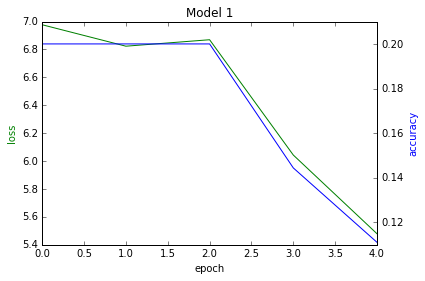

In [34]:
# plot loss and accuracy for model 2
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
LN = len(History.history['val_loss'])
ax1.plot(range(LN),History.history['val_loss'],'g-')
ax2.plot(range(LN),History.history['val_acc'],'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss',color='g')
ax2.set_ylabel('accuracy',color='b')
plt.title('Model 1')

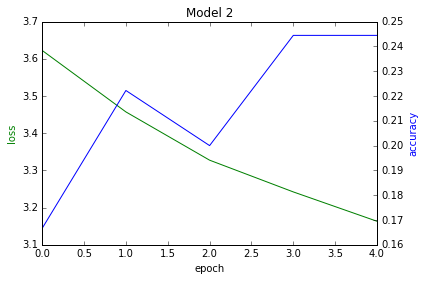

In [30]:
# plot loss and accuracy for model 2
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
LN = len(History2.history['val_loss'])
ax1.plot(range(LN),History2.history['val_loss'],'g-')
ax2.plot(range(LN),History2.history['val_acc'],'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss',color='g')
ax2.set_ylabel('accuracy',color='b')
plt.title('Model 2')